In [181]:
import numpy as np
import pandas as pd
import matplotlib as plt

from load import read_csv, to_csv
from utilities import get_indicator, add_aggregate

In [145]:
path = './Data/bt-impute.csv'

df = read_csv(path)
pd.set_option('display.max_columns', None)

print(len(df))
df.head()

79417


,TUMOURID,PATIENTID,DIAGNOSISDATEBEST,SITE_ICD10_O2_3CHAR,MORPH_ICD10_O2,BEHAVIOUR_ICD10_O2,STAGE_BEST,GRADE,AGE,SEX,CREG_CODE,LINKNUMBER,LATERALITY,QUINTILE_2015,TUMOUR_COUNT,ETHNICITY,DEATHCAUSECODE_2,NEWVITALSTATUS,SACT,DATE_DECISION_TO_TREAT,START_DATE_OF_REGIMEN,CLINICAL_TRIAL,CHEMO_RADIATION,REGIMEN_COUNT,CLINICAL_TRIAL_INDICATOR,CHEMO_RADIATION_INDICATOR,NORMALISED_HEIGHT,NORMALISED_WEIGHT,MERGED_CYCLE_ID,CYCLE_NUMBER,START_DATE_OF_CYCLE,DAYS_TO_FIRST_SURGERY,DAYS_SINCE_DIAGNOSIS
0,10614165,10501771,2017-01-16,C71,9440.0,3,U,G4,69.0,1,L0401,810501771,R,4,2,W,NaN,A,False,NaT,NaT,False,False,0.0,False,False,0.000,0.00,NaN,NaN,NaT,0,751
1,10614166,10501772,2015-11-10,C71,9440.0,3,U,G4,88.0,1,L1001,810501772,R,1,2,W,NaN,D,True,2015-12-15,2015-12-23,False,False,1.0,True,True,1.755,71.75,10003933.0,1.0,2016-06-15,0,17
2,10614166,10501772,2015-11-10,C71,9440.0,3,U,G4,88.0,1,L1001,810501772,R,1,2,W,NaN,D,True,2015-12-15,2015-12-23,False,False,1.0,True,True,1.755,71.75,10012207.0,2.0,2016-07-06,0,17
3,10614166,10501772,2015-11-10,C71,9440.0,3,U,G4,88.0,1,L1001,810501772,R,1,2,W,NaN,D,True,2015-12-15,2015-12-23,False,False,1.0,True,True,1.755,71.75,10017672.0,2.0,2016-08-03,0,17
4,10614166,10501772,2015-11-10,C71,9440.0,3,U,G4,88.0,1,L1001,810501772,R,1,2,W,NaN,D,True,2015-12-15,2015-12-23,False,False,1.0,True,True,1.755,71.75,10021647.0,3.0,2016-08-31,0,17


In [146]:
df = df.drop(df[(df.SITE_ICD10_O2_3CHAR != 'C70') & 
                    (df.SITE_ICD10_O2_3CHAR != 'C71') & 
                    (df.SITE_ICD10_O2_3CHAR != 'C72') & 
                    (df.SITE_ICD10_O2_3CHAR != 'D32') &
                    (df.SITE_ICD10_O2_3CHAR != 'D33') &
                    (df.SITE_ICD10_O2_3CHAR != 'D35')].index)
df.SITE_ICD10_O2_3CHAR = df.SITE_ICD10_O2_3CHAR.cat.remove_unused_categories()
print(df.shape)
df.SITE_ICD10_O2_3CHAR.value_counts()

(79264, 33)


C71    54859
D32    13354
D33     5171
D35     4353
C72     1192
C70      335
Name: SITE_ICD10_O2_3CHAR, dtype: int64

In [147]:
site_dummies = pd.get_dummies(df.SITE_ICD10_O2_3CHAR, prefix='SITE')
# dropping this later
# df = df.drop(columns = 'SITE_ICD10_O2_3CHAR')
df = pd.concat([df, site_dummies], axis=1)
    
print(df.shape)

(79264, 39)


In [148]:
print(df['PATIENTID'].nunique())
patient_ids = df['PATIENTID'].copy()

40100


In [149]:
# df.MORPH_ICD10_O2.value_counts().to_csv('./Data/morph.csv', index=True)
# too little variation
df = df.drop(columns='MORPH_ICD10_O2')

In [150]:
df.BEHAVIOUR_ICD10_O2 = df.BEHAVIOUR_ICD10_O2.replace({2: 0, 5: 3, 6: 3, 9: 3})

# dropping 82 'uncertain' cases encoded as 1
df = df.drop(df[df.BEHAVIOUR_ICD10_O2 == 1].index)

print(df['PATIENTID'].nunique())
print(df.BEHAVIOUR_ICD10_O2.value_counts())

# note that pytorch requires float32 instead of int
# transform elsewhere
df['BENIGN_BEHAVIOUR'] = (df.BEHAVIOUR_ICD10_O2 == 0).astype(int)
df = df.drop(columns= 'BEHAVIOUR_ICD10_O2')
df.head()

40018
3    56857
0    22076
Name: BEHAVIOUR_ICD10_O2, dtype: int64


,TUMOURID,PATIENTID,DIAGNOSISDATEBEST,SITE_ICD10_O2_3CHAR,STAGE_BEST,GRADE,AGE,SEX,CREG_CODE,LINKNUMBER,LATERALITY,QUINTILE_2015,TUMOUR_COUNT,ETHNICITY,DEATHCAUSECODE_2,NEWVITALSTATUS,SACT,DATE_DECISION_TO_TREAT,START_DATE_OF_REGIMEN,CLINICAL_TRIAL,CHEMO_RADIATION,REGIMEN_COUNT,CLINICAL_TRIAL_INDICATOR,CHEMO_RADIATION_INDICATOR,NORMALISED_HEIGHT,NORMALISED_WEIGHT,MERGED_CYCLE_ID,CYCLE_NUMBER,START_DATE_OF_CYCLE,DAYS_TO_FIRST_SURGERY,DAYS_SINCE_DIAGNOSIS,SITE_C70,SITE_C71,SITE_C72,SITE_D32,SITE_D33,SITE_D35,BENIGN_BEHAVIOUR
0,10614165,10501771,2017-01-16,C71,U,G4,69.0,1,L0401,810501771,R,4,2,W,NaN,A,False,NaT,NaT,False,False,0.0,False,False,0.000,0.00,NaN,NaN,NaT,0,751,0,1,0,0,0,0,0
1,10614166,10501772,2015-11-10,C71,U,G4,88.0,1,L1001,810501772,R,1,2,W,NaN,D,True,2015-12-15,2015-12-23,False,False,1.0,True,True,1.755,71.75,10003933.0,1.0,2016-06-15,0,17,0,1,0,0,0,0,0
2,10614166,10501772,2015-11-10,C71,U,G4,88.0,1,L1001,810501772,R,1,2,W,NaN,D,True,2015-12-15,2015-12-23,False,False,1.0,True,True,1.755,71.75,10012207.0,2.0,2016-07-06,0,17,0,1,0,0,0,0,0
3,10614166,10501772,2015-11-10,C71,U,G4,88.0,1,L1001,810501772,R,1,2,W,NaN,D,True,2015-12-15,2015-12-23,False,False,1.0,True,True,1.755,71.75,10017672.0,2.0,2016-08-03,0,17,0,1,0,0,0,0,0
4,10614166,10501772,2015-11-10,C71,U,G4,88.0,1,L1001,810501772,R,1,2,W,NaN,D,True,2015-12-15,2015-12-23,False,False,1.0,True,True,1.755,71.75,10021647.0,3.0,2016-08-31,0,17,0,1,0,0,0,0,0


In [151]:
df = df.drop(columns='STAGE_BEST')
df.head()

,TUMOURID,PATIENTID,DIAGNOSISDATEBEST,SITE_ICD10_O2_3CHAR,GRADE,AGE,SEX,CREG_CODE,LINKNUMBER,LATERALITY,QUINTILE_2015,TUMOUR_COUNT,ETHNICITY,DEATHCAUSECODE_2,NEWVITALSTATUS,SACT,DATE_DECISION_TO_TREAT,START_DATE_OF_REGIMEN,CLINICAL_TRIAL,CHEMO_RADIATION,REGIMEN_COUNT,CLINICAL_TRIAL_INDICATOR,CHEMO_RADIATION_INDICATOR,NORMALISED_HEIGHT,NORMALISED_WEIGHT,MERGED_CYCLE_ID,CYCLE_NUMBER,START_DATE_OF_CYCLE,DAYS_TO_FIRST_SURGERY,DAYS_SINCE_DIAGNOSIS,SITE_C70,SITE_C71,SITE_C72,SITE_D32,SITE_D33,SITE_D35,BENIGN_BEHAVIOUR
0,10614165,10501771,2017-01-16,C71,G4,69.0,1,L0401,810501771,R,4,2,W,NaN,A,False,NaT,NaT,False,False,0.0,False,False,0.000,0.00,NaN,NaN,NaT,0,751,0,1,0,0,0,0,0
1,10614166,10501772,2015-11-10,C71,G4,88.0,1,L1001,810501772,R,1,2,W,NaN,D,True,2015-12-15,2015-12-23,False,False,1.0,True,True,1.755,71.75,10003933.0,1.0,2016-06-15,0,17,0,1,0,0,0,0,0
2,10614166,10501772,2015-11-10,C71,G4,88.0,1,L1001,810501772,R,1,2,W,NaN,D,True,2015-12-15,2015-12-23,False,False,1.0,True,True,1.755,71.75,10012207.0,2.0,2016-07-06,0,17,0,1,0,0,0,0,0
3,10614166,10501772,2015-11-10,C71,G4,88.0,1,L1001,810501772,R,1,2,W,NaN,D,True,2015-12-15,2015-12-23,False,False,1.0,True,True,1.755,71.75,10017672.0,2.0,2016-08-03,0,17,0,1,0,0,0,0,0
4,10614166,10501772,2015-11-10,C71,G4,88.0,1,L1001,810501772,R,1,2,W,NaN,D,True,2015-12-15,2015-12-23,False,False,1.0,True,True,1.755,71.75,10021647.0,3.0,2016-08-31,0,17,0,1,0,0,0,0,0


In [152]:
grade_mapper = {'GX' : -1, 'G0' : 0, 'G1' : 1, 'G2' : 2, 'G3' : 3, 'G4' : 4}
df.GRADE = df.GRADE.replace(grade_mapper)
df.head()

,TUMOURID,PATIENTID,DIAGNOSISDATEBEST,SITE_ICD10_O2_3CHAR,GRADE,AGE,SEX,CREG_CODE,LINKNUMBER,LATERALITY,QUINTILE_2015,TUMOUR_COUNT,ETHNICITY,DEATHCAUSECODE_2,NEWVITALSTATUS,SACT,DATE_DECISION_TO_TREAT,START_DATE_OF_REGIMEN,CLINICAL_TRIAL,CHEMO_RADIATION,REGIMEN_COUNT,CLINICAL_TRIAL_INDICATOR,CHEMO_RADIATION_INDICATOR,NORMALISED_HEIGHT,NORMALISED_WEIGHT,MERGED_CYCLE_ID,CYCLE_NUMBER,START_DATE_OF_CYCLE,DAYS_TO_FIRST_SURGERY,DAYS_SINCE_DIAGNOSIS,SITE_C70,SITE_C71,SITE_C72,SITE_D32,SITE_D33,SITE_D35,BENIGN_BEHAVIOUR
0,10614165,10501771,2017-01-16,C71,4,69.0,1,L0401,810501771,R,4,2,W,NaN,A,False,NaT,NaT,False,False,0.0,False,False,0.000,0.00,NaN,NaN,NaT,0,751,0,1,0,0,0,0,0
1,10614166,10501772,2015-11-10,C71,4,88.0,1,L1001,810501772,R,1,2,W,NaN,D,True,2015-12-15,2015-12-23,False,False,1.0,True,True,1.755,71.75,10003933.0,1.0,2016-06-15,0,17,0,1,0,0,0,0,0
2,10614166,10501772,2015-11-10,C71,4,88.0,1,L1001,810501772,R,1,2,W,NaN,D,True,2015-12-15,2015-12-23,False,False,1.0,True,True,1.755,71.75,10012207.0,2.0,2016-07-06,0,17,0,1,0,0,0,0,0
3,10614166,10501772,2015-11-10,C71,4,88.0,1,L1001,810501772,R,1,2,W,NaN,D,True,2015-12-15,2015-12-23,False,False,1.0,True,True,1.755,71.75,10017672.0,2.0,2016-08-03,0,17,0,1,0,0,0,0,0
4,10614166,10501772,2015-11-10,C71,4,88.0,1,L1001,810501772,R,1,2,W,NaN,D,True,2015-12-15,2015-12-23,False,False,1.0,True,True,1.755,71.75,10021647.0,3.0,2016-08-31,0,17,0,1,0,0,0,0,0


In [153]:
creg_dummies = pd.get_dummies(df.CREG_CODE, prefix='CREG')
df = df.drop(columns = 'CREG_CODE')
df = pd.concat([df, creg_dummies], axis=1)
df.head()

,TUMOURID,PATIENTID,DIAGNOSISDATEBEST,SITE_ICD10_O2_3CHAR,GRADE,AGE,SEX,LINKNUMBER,LATERALITY,QUINTILE_2015,TUMOUR_COUNT,ETHNICITY,DEATHCAUSECODE_2,NEWVITALSTATUS,SACT,DATE_DECISION_TO_TREAT,START_DATE_OF_REGIMEN,CLINICAL_TRIAL,CHEMO_RADIATION,REGIMEN_COUNT,CLINICAL_TRIAL_INDICATOR,CHEMO_RADIATION_INDICATOR,NORMALISED_HEIGHT,NORMALISED_WEIGHT,MERGED_CYCLE_ID,CYCLE_NUMBER,START_DATE_OF_CYCLE,DAYS_TO_FIRST_SURGERY,DAYS_SINCE_DIAGNOSIS,SITE_C70,SITE_C71,SITE_C72,SITE_D32,SITE_D33,SITE_D35,BENIGN_BEHAVIOUR,CREG_L0201,CREG_L0301,CREG_L0401,CREG_L0801,CREG_L0901,CREG_L1001,CREG_L1201,CREG_L1701
0,10614165,10501771,2017-01-16,C71,4,69.0,1,810501771,R,4,2,W,NaN,A,False,NaT,NaT,False,False,0.0,False,False,0.000,0.00,NaN,NaN,NaT,0,751,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
1,10614166,10501772,2015-11-10,C71,4,88.0,1,810501772,R,1,2,W,NaN,D,True,2015-12-15,2015-12-23,False,False,1.0,True,True,1.755,71.75,10003933.0,1.0,2016-06-15,0,17,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,10614166,10501772,2015-11-10,C71,4,88.0,1,810501772,R,1,2,W,NaN,D,True,2015-12-15,2015-12-23,False,False,1.0,True,True,1.755,71.75,10012207.0,2.0,2016-07-06,0,17,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,10614166,10501772,2015-11-10,C71,4,88.0,1,810501772,R,1,2,W,NaN,D,True,2015-12-15,2015-12-23,False,False,1.0,True,True,1.755,71.75,10017672.0,2.0,2016-08-03,0,17,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,10614166,10501772,2015-11-10,C71,4,88.0,1,810501772,R,1,2,W,NaN,D,True,2015-12-15,2015-12-23,False,False,1.0,True,True,1.755,71.75,10021647.0,3.0,2016-08-31,0,17,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [154]:
lat_dummies = pd.get_dummies(df.LATERALITY, prefix='LAT')
df = df.drop(columns = 'LATERALITY')
df = pd.concat([df, lat_dummies], axis=1)

In [155]:
eth_dummies = pd.get_dummies(df.ETHNICITY, prefix='ETH')
df = df.drop(columns = 'ETHNICITY')
df = pd.concat([df, eth_dummies], axis=1)

In [156]:
# only 80 censored
# EVENT means not alive 
# df = df.drop(df[df.NEWVITALSTATUS == 'X'].index)
vital_mapper = {'A' : 0, 'X' : 0, 'D' : 1}
df['EVENT'] = df.NEWVITALSTATUS.replace(vital_mapper)
df = df.drop(columns='NEWVITALSTATUS')


In [157]:
df.SACT = df.SACT.astype(int)
df.CLINICAL_TRIAL_INDICATOR = df.CLINICAL_TRIAL_INDICATOR.astype(int)
df.CHEMO_RADIATION_INDICATOR = df.CHEMO_RADIATION_INDICATOR.astype(int)

In [158]:
df.head() 

,TUMOURID,PATIENTID,DIAGNOSISDATEBEST,SITE_ICD10_O2_3CHAR,GRADE,AGE,SEX,LINKNUMBER,QUINTILE_2015,TUMOUR_COUNT,DEATHCAUSECODE_2,SACT,DATE_DECISION_TO_TREAT,START_DATE_OF_REGIMEN,CLINICAL_TRIAL,CHEMO_RADIATION,REGIMEN_COUNT,CLINICAL_TRIAL_INDICATOR,CHEMO_RADIATION_INDICATOR,NORMALISED_HEIGHT,NORMALISED_WEIGHT,MERGED_CYCLE_ID,CYCLE_NUMBER,START_DATE_OF_CYCLE,DAYS_TO_FIRST_SURGERY,DAYS_SINCE_DIAGNOSIS,SITE_C70,SITE_C71,SITE_C72,SITE_D32,SITE_D33,SITE_D35,BENIGN_BEHAVIOUR,CREG_L0201,CREG_L0301,CREG_L0401,CREG_L0801,CREG_L0901,CREG_L1001,CREG_L1201,CREG_L1701,LAT_9,LAT_B,LAT_L,LAT_M,LAT_R,ETH_A,ETH_B,ETH_C,ETH_M,ETH_O,ETH_U,ETH_W,EVENT
0,10614165,10501771,2017-01-16,C71,4,69.0,1,810501771,4,2,NaN,0,NaT,NaT,False,False,0.0,0,0,0.000,0.00,NaN,NaN,NaT,0,751,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,10614166,10501772,2015-11-10,C71,4,88.0,1,810501772,1,2,NaN,1,2015-12-15,2015-12-23,False,False,1.0,1,1,1.755,71.75,10003933.0,1.0,2016-06-15,0,17,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1
2,10614166,10501772,2015-11-10,C71,4,88.0,1,810501772,1,2,NaN,1,2015-12-15,2015-12-23,False,False,1.0,1,1,1.755,71.75,10012207.0,2.0,2016-07-06,0,17,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1
3,10614166,10501772,2015-11-10,C71,4,88.0,1,810501772,1,2,NaN,1,2015-12-15,2015-12-23,False,False,1.0,1,1,1.755,71.75,10017672.0,2.0,2016-08-03,0,17,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1
4,10614166,10501772,2015-11-10,C71,4,88.0,1,810501772,1,2,NaN,1,2015-12-15,2015-12-23,False,False,1.0,1,1,1.755,71.75,10021647.0,3.0,2016-08-31,0,17,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1


<ipython-input-186-9572de0772f5>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=[5000*i for i in range(11)],fontsize=14)


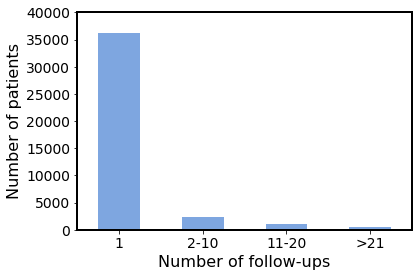

In [186]:
patient_count = df.groupby('PATIENTID').size().value_counts(bins=[0,1,10,20,60])
# patient_count = df.groupby('PATIENTID').size().value_counts(bins=[0,1,5,10,15,20,25,30,35,40,45,50,55])
ax = patient_count.plot(kind='bar', color='#7EA6E0')
for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(2)
ax.set_ylim(0,40000)
ax.set_yticklabels(labels=[5000*i for i in range(11)],fontsize=14)
ax.set_ylabel('Number of patients', fontsize=16)

# print(np.arange(0,70,5))
ax.set_xticklabels(['1','2-10','11-20','>21'], fontsize=14, rotation=0)
# ax.set_xticklabels(['1','2-5','6-10','11-15','16-20','21-25','26-30','31-35','36-40','41-45','46-50','51-55'])
ax.set_xlabel('Number of follow-ups', fontsize=16)
fig = ax.get_figure()
fig.savefig('followups.eps', format='eps', bbox_inches='tight')

In [133]:
print(df.SITE_ICD10_O2_3CHAR.value_counts())
df = df.drop(columns = 'SITE_ICD10_O2_3CHAR')


C71    54827
D32    13118
D33     5111
D35     4353
C72     1190
C70      334
Name: SITE_ICD10_O2_3CHAR, dtype: int64


In [134]:
### flattening to only keep latest, most complete entry 
print(df['PATIENTID'].nunique())
to_max = ['GRADE','TUMOUR_COUNT','SACT','REGIMEN_COUNT','CLINICAL_TRIAL_INDICATOR','NORMALISED_HEIGHT','NORMALISED_WEIGHT','CHEMO_RADIATION_INDICATOR','DAYS_TO_FIRST_SURGERY','DAYS_SINCE_DIAGNOSIS','BENIGN_BEHAVIOUR']
to_max = to_max + list(df.columns[df.columns.str.startswith('SITE_') | df.columns.str.startswith('LAT_') | df.columns.str.startswith('CREG_')])
to_median = ['QUINTILE_2015']
to_min = ['AGE']

for m in to_max:
    df = add_aggregate(df,what='max',target=m,groupby='PATIENTID',name=m)
for m in to_median:
    df = add_aggregate(df,what='median',target=m,groupby='PATIENTID',name=m)
for m in to_min:
    df = add_aggregate(df,what='min',target=m,groupby='PATIENTID',name=m)
df.head()

40018
lost:  0
lost:  0
lost:  0
lost:  0
lost:  0
lost:  0
lost:  0
lost:  0
lost:  0
lost:  0
lost:  0
lost:  0
lost:  0
lost:  0
lost:  0
lost:  0
lost:  0
lost:  0
lost:  0
lost:  0
lost:  0
lost:  0
lost:  0
lost:  0
lost:  0
lost:  0
lost:  0
lost:  0
lost:  0
lost:  0
lost:  0
lost:  0


,TUMOURID,PATIENTID,DIAGNOSISDATEBEST,GRADE,AGE,SEX,LINKNUMBER,QUINTILE_2015,TUMOUR_COUNT,DEATHCAUSECODE_2,SACT,DATE_DECISION_TO_TREAT,START_DATE_OF_REGIMEN,CLINICAL_TRIAL,CHEMO_RADIATION,REGIMEN_COUNT,CLINICAL_TRIAL_INDICATOR,CHEMO_RADIATION_INDICATOR,NORMALISED_HEIGHT,NORMALISED_WEIGHT,MERGED_CYCLE_ID,CYCLE_NUMBER,START_DATE_OF_CYCLE,DAYS_TO_FIRST_SURGERY,DAYS_SINCE_DIAGNOSIS,SITE_C70,SITE_C71,SITE_C72,SITE_D32,SITE_D33,SITE_D35,BENIGN_BEHAVIOUR,CREG_L0201,CREG_L0301,CREG_L0401,CREG_L0801,CREG_L0901,CREG_L1001,CREG_L1201,CREG_L1701,LAT_9,LAT_B,LAT_L,LAT_M,LAT_R,ETH_A,ETH_B,ETH_C,ETH_M,ETH_O,ETH_U,ETH_W,EVENT
0,10614165,10501771,2017-01-16,4,69.0,1,810501771,4.0,2,NaN,0,NaT,NaT,False,False,0.0,0,0,0.000,0.00,NaN,NaN,NaT,0,751,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,10614166,10501772,2015-11-10,4,88.0,1,810501772,1.0,2,NaN,1,2015-12-15,2015-12-23,False,False,5.0,1,1,1.755,71.75,10003933.0,1.0,2016-06-15,0,17,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1
2,10614166,10501772,2015-11-10,4,88.0,1,810501772,1.0,2,NaN,1,2015-12-15,2015-12-23,False,False,5.0,1,1,1.755,71.75,10012207.0,2.0,2016-07-06,0,17,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1
3,10614166,10501772,2015-11-10,4,88.0,1,810501772,1.0,2,NaN,1,2015-12-15,2015-12-23,False,False,5.0,1,1,1.755,71.75,10017672.0,2.0,2016-08-03,0,17,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1
4,10614166,10501772,2015-11-10,4,88.0,1,810501772,1.0,2,NaN,1,2015-12-15,2015-12-23,False,False,5.0,1,1,1.755,71.75,10021647.0,3.0,2016-08-31,0,17,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1


In [135]:
df['PATIENTID'].nunique()

40018

In [136]:
# should be 82 as per above (uncertain cases)
lost = set(patient_ids) - set(df.PATIENTID)
print(len(lost))

82


In [137]:
# this should go last
df = df.drop(columns = ['DIAGNOSISDATEBEST', 'DATE_DECISION_TO_TREAT', 'START_DATE_OF_REGIMEN', 'DATE_DECISION_TO_TREAT', 'START_DATE_OF_REGIMEN']) 
df = df.drop(columns = ['CLINICAL_TRIAL', 'CHEMO_RADIATION'])
# might include cycle info later
df = df.drop(columns = ['MERGED_CYCLE_ID','CYCLE_NUMBER', 'START_DATE_OF_CYCLE'])
df = df.drop(columns = ['DEATHCAUSECODE_2'])
df = df.drop(columns = ['TUMOURID','LINKNUMBER'])
df = df.drop_duplicates()
print(df['PATIENTID'].nunique())
# df = df.drop(columns = ['PATIENTID'])


40018


In [138]:
# unscaled pandas 
print(len(df))
to_csv(df, './Data/data.csv', index=False)

# this would give headerless numpy 
# data = scale(df)
# np.savetxt("./Data/data.csv", data, delimiter=",")

40018


In [139]:
pd.set_option('display.max_rows', None)
df.dtypes


PATIENTID                       int64
GRADE                           int64
AGE                           float64
SEX                          category
QUINTILE_2015                 float64
TUMOUR_COUNT                    int64
SACT                            int64
REGIMEN_COUNT                 float64
CLINICAL_TRIAL_INDICATOR        int64
CHEMO_RADIATION_INDICATOR       int64
NORMALISED_HEIGHT             float64
NORMALISED_WEIGHT             float64
DAYS_TO_FIRST_SURGERY           int64
DAYS_SINCE_DIAGNOSIS            int64
SITE_C70                        uint8
SITE_C71                        uint8
SITE_C72                        uint8
SITE_D32                        uint8
SITE_D33                        uint8
SITE_D35                        uint8
BENIGN_BEHAVIOUR                int64
CREG_L0201                      uint8
CREG_L0301                      uint8
CREG_L0401                      uint8
CREG_L0801                      uint8
CREG_L0901                      uint8
CREG_L1001  